In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal
from torchvision.utils import make_grid, save_image
import tqdm
import matplotlib.pyplot as plt

from ex2mcmc.samplers import mala, isir, ex2mcmc
from ex2mcmc.utils.general_utils import CHECKPOINT_DIR, PROJECT_PATH, IMGS_DIR, random_seed

from gan_mnist import GeneratorMNIST, DiscriminatorMNIST

2023-04-20 15:40:29.194228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
latent_dim = 2
batch_size = 128

gen = GeneratorMNIST(latent_dim).to(device).eval()
dis = DiscriminatorMNIST(wgan_cp=True).to(device).eval()
gen.load_state_dict(torch.load(Path(CHECKPOINT_DIR, 'MNIST/wgan.pth'))[0])
dis.load_state_dict(torch.load(Path(CHECKPOINT_DIR, 'MNIST/wgan.pth'))[1])
prior = MNormal(torch.zeros(latent_dim).to(device), torch.eye(latent_dim).to(device))

In [12]:
class TargetGAN:
    def __init__(self, gen, dis, prior, batch_size: int = 128):
        self.gen = gen
        self.dis = dis
        self.prior = prior
        self.batch_size = batch_size
        
    def log_prob_batch(self, z: torch.Tensor):
        return self.dis(self.gen(z)).squeeze() + self.prior.log_prob(z)
        
    def log_prob(self, z: torch.Tensor):
        z_flat = z.reshape(-1, z.shape[-1])
        batch_size = self.batch_size
        res = []
        for i in range(z_flat.shape[0] // batch_size + (1 if z_flat.shape[0] % batch_size else 0)):
            res.append(self.log_prob_batch(z_flat[batch_size * i: batch_size * (i+1)]))
    
        return torch.cat(res, 0).reshape(z.shape[:-1])

target = TargetGAN(gen, dis, prior, batch_size=batch_size)

In [13]:
random_seed(42)

N_samples = 3
a = 2

start = prior.sample((N_samples,)).clone()

# I-SIR

In [14]:
random_seed(42)

sigma_isir = 3.0
isir_proposal = MNormal(
    torch.zeros(latent_dim).to(device), 
    (sigma_isir ** 2) * torch.eye(latent_dim).to(device))

N_particles = 10
N_steps = 100

Samples_isir, _ = isir(start, target, isir_proposal, N_steps, 0, n_particles=N_particles)
energies_isir = -target.log_prob(Samples_isir.reshape(-1, latent_dim)).reshape(N_samples, N_steps).detach().cpu()

100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


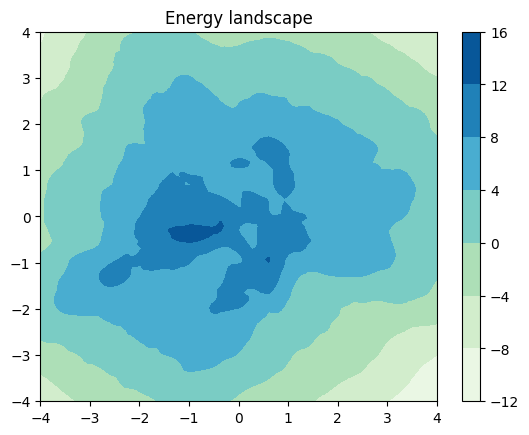

In [15]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, N_pts)
ylist = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[:, :, 0] = X
points[:, :, 1] = Y
points = points.reshape(-1, 2)
        
dens_vals = []
prop_vals = []
for i in tqdm.tqdm(range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0))):
    z = torch.FloatTensor(points[i * batch_size: (i + 1) * batch_size]).to(device)
    dens_vals.append(target.log_prob(z).detach().cpu().numpy())
    prop_vals.append(isir_proposal.log_prob(z).detach().cpu().numpy())

dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)
prop_vals = np.concatenate(prop_vals).reshape(N_pts, N_pts)

fig, ax = plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
fig.colorbar(cp)
ax.set_title('Energy landscape')
plt.show()

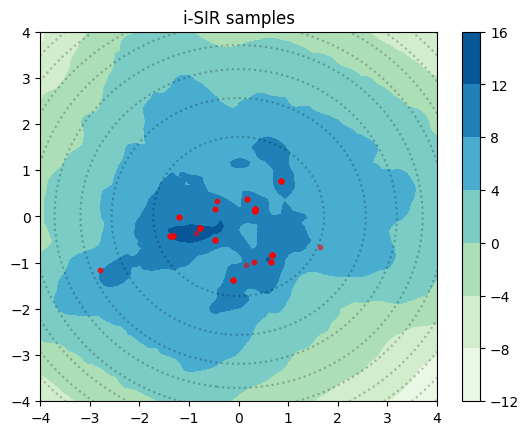

In [16]:
fig, ax = plt.subplots(1,1)

cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
ax.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
fig.colorbar(cp)
ax.scatter(Samples_isir[:, 0, 0], Samples_isir[:, 0, 1], s=10, c='r', alpha=0.5)
ax.set_title(r'i-SIR samples')
plt.show()

# MALA 

In [17]:
random_seed(42)

N_steps = 100
mala_iters = 3

mala_proposal = MNormal(
   torch.zeros(latent_dim).to(device), 
   torch.eye(latent_dim).to(device))

Samples_mala, meta = mala(start, target, mala_proposal, mala_iters * N_steps, 0, , step_size=0.01, target_acceptance=0.67)
Samples_mala = Samples_mala[::mala_iters]

energies_mala = -target.log_prob(Samples_mala.reshape(-1, latent_dim)).reshape(N_samples, N_steps).detach().cpu()

In [ ]:
meta['step_size'][-1]

# Ex2MCMC

In [32]:
random_seed(42)

N_steps = 100

sigma_isir = 3.0
isir_proposal = MNormal(
    torch.zeros(latent_dim).to(device), 
    (sigma_isir ** 2) * torch.eye(latent_dim).to(device))

N_particles = 10
mala_iters = 3

Samples_ex2, meta = ex2mcmc(
    start, target, isir_proposal, N_steps, 0, step_size=0.01, 
    target_acceptance=0.67, n_particles=N_particles, n_mala_steps=mala_iters
)

energies_ex2 = -target.log_prob(Samples_ex2.reshape(-1, latent_dim)).reshape(N_samples, N_steps).detach().cpu()

In [33]:
meta['step_size'][-1]

0.015513282159785164

In [34]:
np.mean(meta['sir_accept'])

0.26666667461395266

### Plot all 3 pictures together

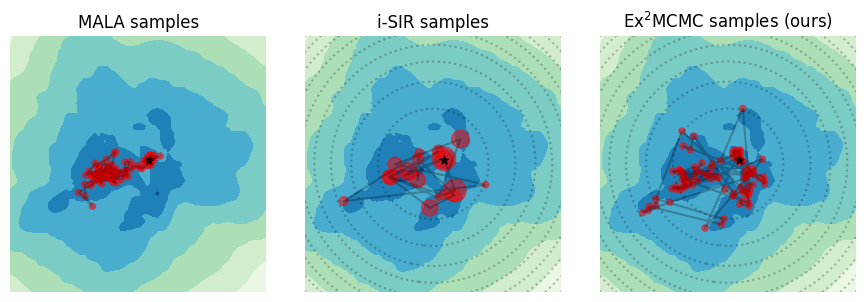

In [35]:
fig, axs = plt.subplots(1 ,3, figsize=(9, 3))
    
chainss = [Samples_mala[:, 0], Samples_isir[:, 0], Samples_ex2[:, 0]]
titles = ['MALA samples', 'i-SIR samples', 'Ex$^2$MCMC samples (ours)']
for idx, (ax, chains, title) in enumerate(zip(axs, chainss, titles)):
    ax.set_title(title)
    ax.contourf(X, Y, dens_vals, cmap='GnBu')
    if idx > 0:
        ax.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.axis('off')
    ax.set_aspect('equal')
    
    xs = chains.detach().cpu()
    posx, invx, countsx = torch.unique_consecutive(xs[:, 0], return_counts=True, return_inverse=True)
    posy, invy, countsy = torch.unique_consecutive(xs[:, 1], return_counts=True, return_inverse=True)

    ax.plot(xs[:, 0], xs[:, 1], '-', c='k', alpha=0.25)
    ax.scatter(posx, posy, marker='o', c='r', alpha=0.5, s=countsx*20)
    ax.scatter(start[0,0], start[0,1],  marker='*', c='k', alpha=0.75, s=40)
    

fig.tight_layout()
# plt.savefig(Path(IMGS_DIR, 'energy_landscape.png'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


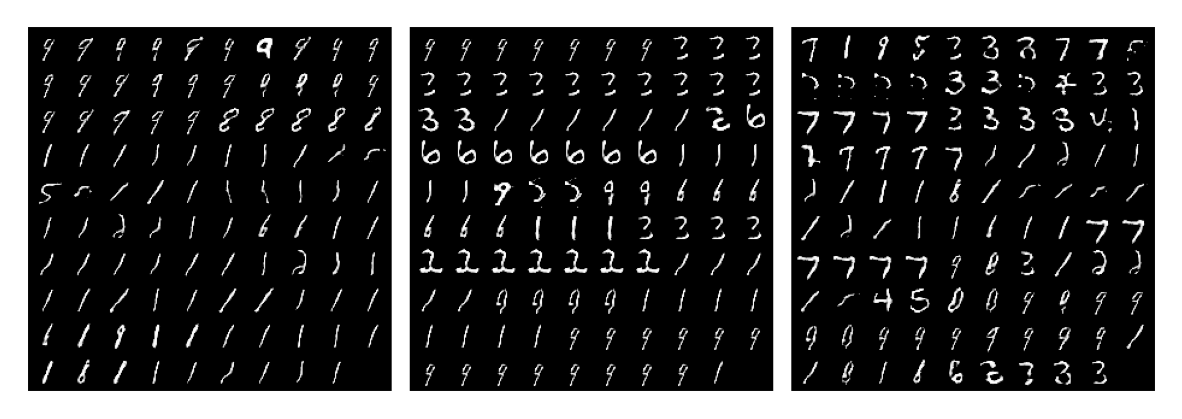

In [37]:
grids = []
for sample in (Samples_mala[:, 0], Samples_isir[:, 0], Samples_ex2[:, 0]):
    sampled_mnist = gen(torch.FloatTensor(sample[1:, :]))
    grid = make_grid(sampled_mnist, nrow=10)
    grids.append(grid)

grid = make_grid(grids, nrow=3, padding=15, pad_value=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()